In [188]:
from pathlib import Path
from datetime import date

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa

import matplotlib.pyplot as plt
import seaborn as sns

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

from sklearn.metrics import r2_score, mean_absolute_error

from constants import tol
from stats import get_stats

ncs_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs')
insitu_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu')
ds = xr.open_dataset(ncs_dir.joinpath('final_insitu.nc'))
insitu = pd.read_parquet(insitu_dir.joinpath('all_difference.parq'))
snotel = pd.read_parquet(insitu_dir.joinpath('snotel.parq'))

fig_dir = Path('../../../figures/insitu/')

In [189]:
# boards = pd.read_parquet(insitu_dir.joinpath('storm_boards.parq'))
# boards['time1'] = pd.to_datetime(boards['date_t1'].dt.strftime('%Y-%m-%d') +'T'+ boards['time_t2'], format='mixed')
# boards['lat'] = boards.latitude
# boards['lon'] = boards.longitude
# boards['dSD'] = boards.hn
# boards['dSWE'] = boards.swe
# boards['t1_density'] = boards.den
# boards['t2_density'] = boards.den

# boards = boards[(~boards.site.str.contains('Bog')) & (~boards.site.str.contains('BB')) & (~boards.comments.str.contains('melt'))]

# insitu = pd.concat([insitu, boards])

In [190]:
def get_uavsar_sd(r, col, SWE = False):
    try:
        site_tol = tol
        x_slice = slice(r.lon - site_tol, r.lon + site_tol)
        y_slice = slice(r.lat + site_tol, r.lat - site_tol)
        site = ds.sel(time1 = r.time1, method = 'nearest').sel(x = x_slice, y = y_slice)
        # site = site.where(site['cor'] > 0.3)

        density = np.nanmean([r['t1_density'], r['t2_density']]) #np.abs(r['dSWE']/r['dSD'])*1000 # r['t1_density']
        uavsar_sd = depth_from_phase(site[col], site['inc'], density = density).mean().data.ravel()[0]
        # if np.abs(uavsar_sd) > 300:
        #     return np.nan
        if SWE:
            return uavsar_sd * density / 997
        return uavsar_sd
    except ZeroDivisionError:
        print('here')
        return np.nan

def get_model_sd(r, SWE = False):
    site = ds.sel(time1 = r.time1, method = 'nearest').sel(x = r.lon, y = r.lat, method = 'nearest', tolerance = tol)
    model_sd = site['model_d_swe'] * 997 / r['t1_density']
    if SWE:
        return site['model_d_swe'].data.ravel()[0]
    return model_sd.data.ravel()[0]

In [191]:
# ds = ds.assign_coords(insitu_hn = ('time1', insitu.groupby('time1')['dSD'].mean()))
# ds = ds.assign_coords(insitu_dSWE = ('time1', insitu.groupby('time1')['dSWE'].mean()))
# den = insitu.groupby('time1')['t1_density'].mean()
# ds = ds.assign_coords(insitu_den = ('time1', den))

In [193]:
# get sd site specific retreivals
insitu['int_atm_sd'] = insitu.apply(get_uavsar_sd, axis = 1, args =  ['int_atm'])
insitu['unw_atm_sd'] = insitu.apply(get_uavsar_sd, axis = 1, args =  ['unw_atm'])
insitu['int_sd'] = insitu.apply(get_uavsar_sd, axis = 1, args =  ['int_phase'])
insitu['unw_sd'] = insitu.apply(get_uavsar_sd, axis = 1, args =  ['unw'])

# get swe site retreivals
insitu['int_atm_swe'] = insitu.apply(get_uavsar_sd, axis = 1, args =  ['int_atm', True])
insitu['unw_atm_swe'] = insitu.apply(get_uavsar_sd, axis = 1, args =  ['unw_atm', True])
insitu['int_swe'] = insitu.apply(get_uavsar_sd, axis = 1, args =  ['int_phase', True])
insitu['unw_swe'] = insitu.apply(get_uavsar_sd, axis = 1, args =  ['unw', True])

# get model site data
insitu['model_d_sd'] = insitu.apply(get_model_sd, axis = 1)
insitu['model_d_swe'] = insitu.apply(get_model_sd, axis = 1, args = [True])

/bsuhome/zacharykeskinen/miniconda3/envs/validation/lib/python3.11/site-packages/uavsar_pytools/snow_depth_inversion.py:55: RuntimeWarning: Mean of empty slice
  if np.nanmean(inc_angle) > 2*np.pi:
/bsuhome/zacharykeskinen/miniconda3/envs/validation/lib/python3.11/site-packages/uavsar_pytools/snow_depth_inversion.py:55: RuntimeWarning: Mean of empty slice
  if np.nanmean(inc_angle) > 2*np.pi:
/bsuhome/zacharykeskinen/miniconda3/envs/validation/lib/python3.11/site-packages/uavsar_pytools/snow_depth_inversion.py:55: RuntimeWarning: Mean of empty slice
  if np.nanmean(inc_angle) > 2*np.pi:
/bsuhome/zacharykeskinen/miniconda3/envs/validation/lib/python3.11/site-packages/uavsar_pytools/snow_depth_inversion.py:55: RuntimeWarning: Mean of empty slice
  if np.nanmean(inc_angle) > 2*np.pi:
/bsuhome/zacharykeskinen/miniconda3/envs/validation/lib/python3.11/site-packages/uavsar_pytools/snow_depth_inversion.py:55: RuntimeWarning: Mean of empty slice
  if np.nanmean(inc_angle) > 2*np.pi:
/bsuhome/z

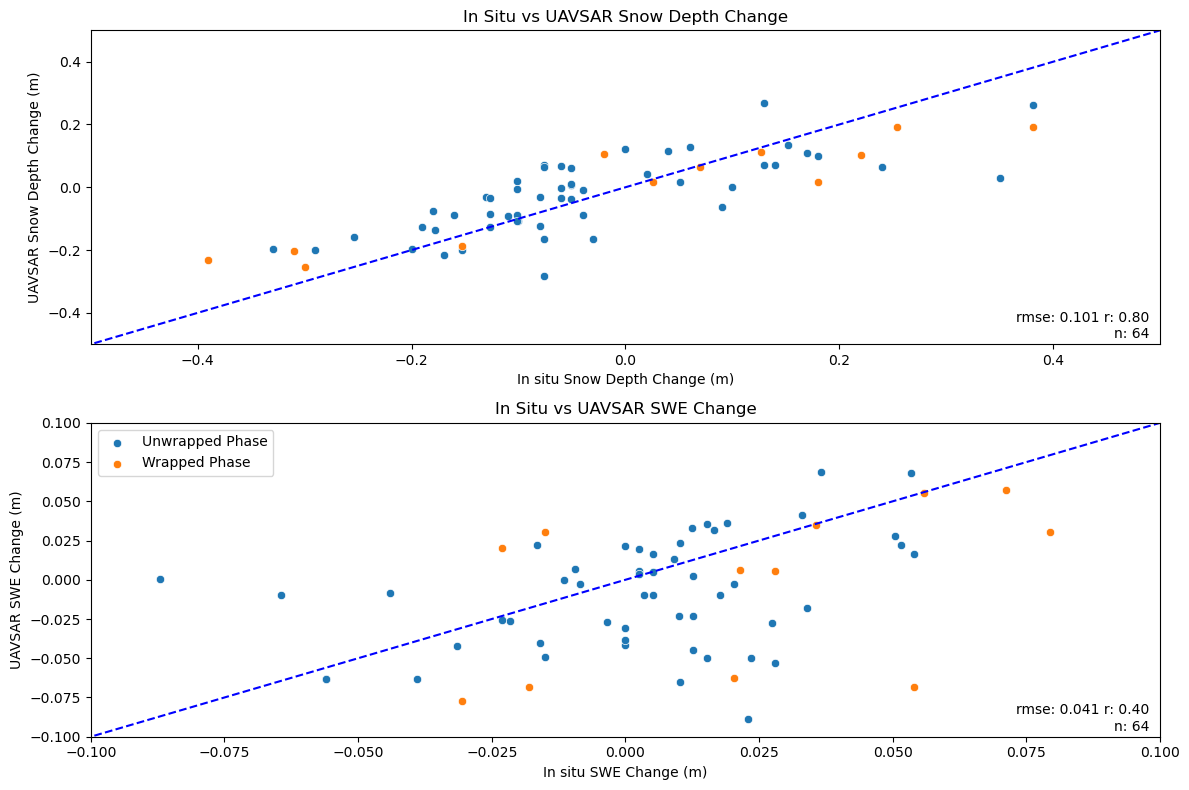

In [198]:
fig, axes = plt.subplots(2, 1, figsize = (12, 8))

for ax in axes:
    ax.plot([-1,1],[-1,1], color = 'blue', linestyle = 'dashed')
im_type = 'unw_atm'
ax = axes[0]
sns.scatterplot(insitu, x = 'dSD', y = f'{im_type}_sd', ax = ax, label = "Unwrapped Phase")
sns.scatterplot(insitu[np.isnan(insitu[f'{im_type}_sd'])], x = 'dSD', y = f"{im_type.replace('unw','int')}_sd", ax = ax, label = "Wrapped Phase")

ax.set_xlabel('In situ Snow Depth Change (m)')
ax.set_ylabel('UAVSAR Snow Depth Change (m)')
xs = pd.concat([insitu[~np.isnan(insitu[f'{im_type}_sd'])][f'{im_type}_sd'], insitu[np.isnan(insitu[f'{im_type}_sd'])][f"{im_type.replace('unw','int')}_sd"]])
ys = pd.concat([insitu[~np.isnan(insitu[f'{im_type}_sd'])]['dSD'], insitu[np.isnan(insitu[f'{im_type}_sd'])]['dSD']])
rmse, r, n = get_stats(xs, ys)
ax.text(s = f'rmse: {rmse:.3f} r: {r:.2f}\nn: {n}', x = 0.99, y = 0.01, ha = 'right', va = 'bottom', transform=ax.transAxes)
ax.set_title('In Situ vs UAVSAR Snow Depth Change')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.get_legend().remove()

ax = axes[1]

sns.scatterplot(insitu, x = 'dSWE', y = f'{im_type}_swe', ax = ax, label = "Unwrapped Phase")
sns.scatterplot(insitu[np.isnan(insitu[f'{im_type}_swe'])], x = 'dSWE', y = f"{im_type.replace('unw','int')}_swe", ax = ax, label = "Wrapped Phase")
ax.set_xlabel('In situ SWE Change (m)')
ax.set_ylabel('UAVSAR SWE Change (m)')
xs = pd.concat([insitu[~np.isnan(insitu[f'{im_type}_swe'])][f'{im_type}_swe'], insitu[np.isnan(insitu[f'{im_type}_swe'])][f"{im_type.replace('unw','int')}_swe"]])
ys = pd.concat([insitu[~np.isnan(insitu[f'{im_type}_swe'])]['dSWE'], insitu[np.isnan(insitu[f'{im_type}_swe'])]['dSWE']])
rmse, r, n = get_stats(xs, ys)
ax.text(s = f'rmse: {rmse:.3f} r: {r:.2f}\nn: {n}', x = 0.99, y = 0.01, ha = 'right', va = 'bottom', transform=ax.transAxes)
ax.set_title('In Situ vs UAVSAR SWE Change')

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)

plt.tight_layout()

plt.savefig(fig_dir.joinpath('insitu_compare_2panel.png'))

Text(0.5, 1.0, 'In Situ vs SnowModel SWE Change')

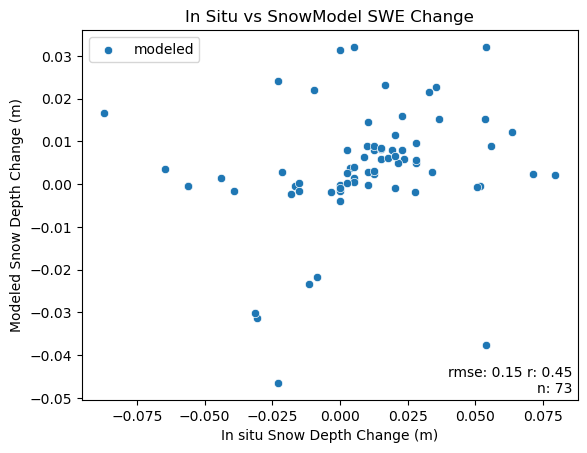

In [50]:
fig, ax = plt.subplots()
sns.scatterplot(insitu, x = 'dSWE', y = 'model_d_swe', ax = ax, label = "modeled")
ax.set_xlabel('In situ Snow Depth Change (m)')
ax.set_ylabel('Modeled Snow Depth Change (m)')
rmse, r, n = get_stats(insitu['dSD'], insitu['model_d_sd'])
ax.text(s = f'rmse: {rmse:.2f} r: {r:.2f}\nn: {n}', x = 0.99, y = 0.01, ha = 'right', va = 'bottom', transform=ax.transAxes)
ax.set_title('In Situ vs SnowModel SWE Change')

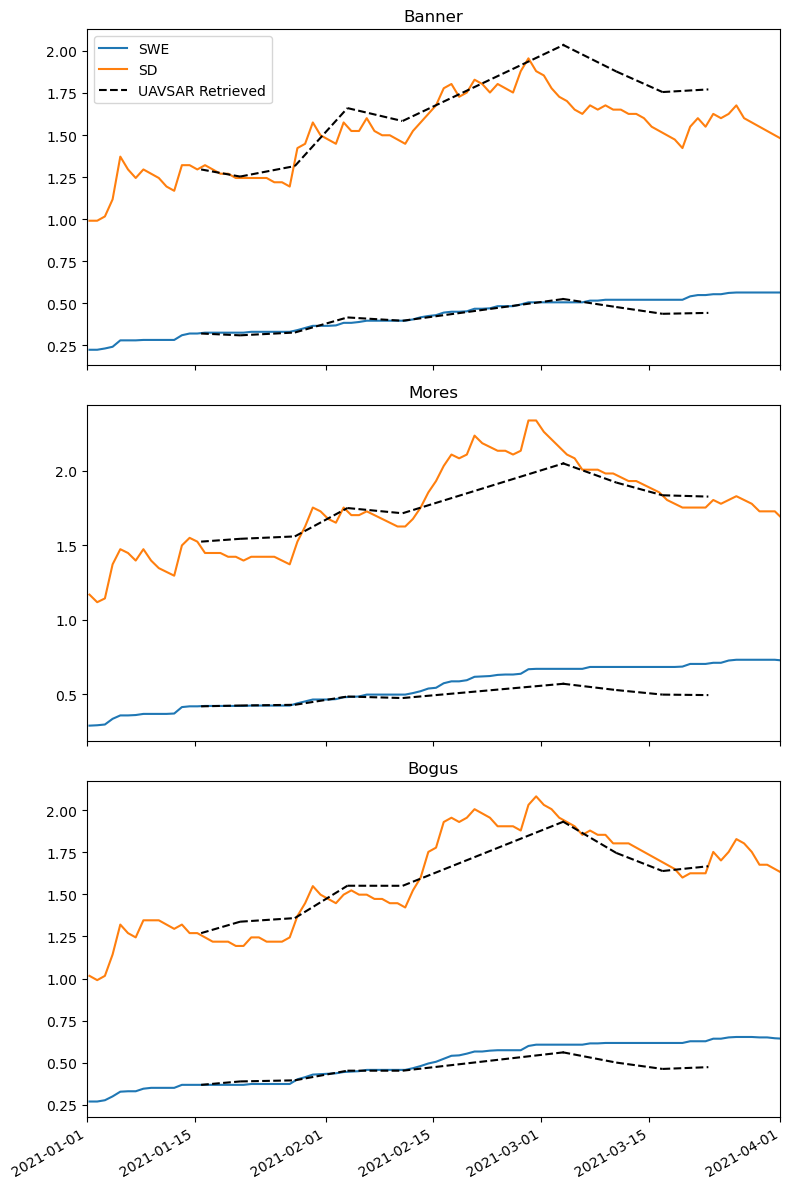

In [303]:
fig, axes = plt.subplots(3, figsize = (8, 12))
for snotel_name, ax in zip(['banner', 'mores', 'bogus'], axes):
    # plot snotel data first
    snotel_data = snotel[snotel.site_name == snotel_name].droplevel('site')
    snotel_data['2021-01-01':][['SWE', 'SD']].plot(ax = ax)
    
    # plot uavsar
    df = insitu[(insitu.site_name == snotel_name) & (insitu.time1.dt.year == 2021)]
    df = df.sort_values('time1')
    for j, (i, r) in enumerate(df.iterrows()):
        if j == 0:
            swe_initial = r.t1_SWE
            sd_initial = r.t1_SD

        # ax.plot([r.time1, r.time2], [swe_initial, swe_initial+ r.dSWE], color = 'C0', linestyle = '-')
        ax.plot([r.time1, r.time2], [swe_initial, swe_initial+ r.int_atm_swe], color = 'black', linestyle = '--')
        swe_initial += r.int_atm_swe

        # ax.plot([r.time1, r.time2], [sd_initial, sd_initial+ r.dSD], color = 'C1', linestyle = '-')
        ax.plot([r.time1, r.time2], [sd_initial, sd_initial+ r.int_atm_sd], color = 'black', linestyle = '--')
        sd_initial += r.int_atm_sd
        
        if r.time2.date() == date(2021, 2, 10):
            # have to fill in for the period we didn't add to this netcdf
            old_ds = xr.open_dataset(ncs_dir.joinpath('old','232_2021-02-10_2021-03-03.sd.nc')).sel(x = slice(r.lon - tol, r.lon + tol), y = slice(r.lat + tol, r.lat - tol))
            d_swe = old_ds['sd_delta_int'].mean() * old_ds.attrs['mean_density'] / 997
            # ax.plot([pd.to_datetime('2021-02-11'), pd.to_datetime('2021-03-04')], [swe_initial, swe_initial+ d_swe], color = 'C0', linestyle = '-', label = 'UAVSAR SWE')
            ax.plot([pd.to_datetime('2021-02-11'), pd.to_datetime('2021-03-04')], [swe_initial, swe_initial+ d_swe], color = 'black', linestyle = '--')
            swe_initial += d_swe

            d_sd = old_ds['sd_delta_int'].mean()
            # ax.plot([pd.to_datetime('2021-02-11'), pd.to_datetime('2021-03-04')], [sd_initial, sd_initial+ d_sd], color = 'C1', linestyle = '-')
            ax.plot([pd.to_datetime('2021-02-11'), pd.to_datetime('2021-03-04')], [sd_initial, sd_initial+ d_sd], color = 'black', linestyle = '--', label = 'UAVSAR Retrieved')
            sd_initial += d_sd
    ax.set_title(snotel_name.capitalize())
    ax.legend()
for ax in axes[1:]:
    ax.legend().remove()

for ax in axes[:2]:
    ax.set_xticklabels([])

for ax in axes:
    ax.set_xlabel('')
    ax.set_xlim([date(2021, 1, 1), date(2021, 4, 1)])

plt.tight_layout()
plt.savefig(fig_dir.joinpath('snotel_swe_sd_ts.png'))